## 1. Find the camera matrix and distortion Co-efficients

In [1]:
# import essential modules
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import os
# %matplotlib qt
%matplotlib inline

In [2]:
def camera_calibration(directory_path=None):
    assert directory_path, "Please provide directory Path"
    
    path_calibration = directory_path
    calibration_images = os.listdir(path_calibration)

    obj_point_list = []
    img_point_list = []

    #Getting Objectpoints 
    obj_points = np.zeros((9*6,3), np.float32)
    obj_points[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    #iterating through all images in the folder 
    for image in calibration_images:
        # generate the actual path of the image
        img_path = os.path.join(path_calibration, image)
        img = mpimg.imread(img_path)
        # convert the image to gray scale as the findChessboardCorners takes only gray scale images
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray,(9,6), None)
        if ret:
            obj_point_list.append(obj_points)
            img_point_list.append(corners)

    # get the camera matrix and distorted matrix
    return cv2.calibrateCamera(obj_point_list, img_point_list, gray.shape[::-1], None, None)

ret, mtx, dist, rvec, tvec = camera_calibration("camera_cal/")



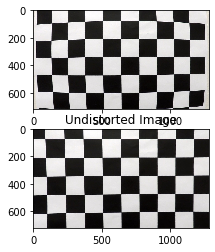

In [3]:
def undistort_image(image_path, camera_matrix, distortion_matrix):
    # Read the image
    img = mpimg.imread(image_path)
    # Apply the camera matrix and distortion matrix to undistort the given image
    return cv2.undistort(img, camera_matrix, distortion_matrix, None, camera_matrix)

plt.subplot(211)
plt.imshow(mpimg.imread("camera_cal/calibration1.jpg"))
undistorted_img = undistort_image("camera_cal/calibration1.jpg", mtx, dist)
plt.subplot(212)
plt.title("Undistorted Image")
plt.imshow(undistorted_img)

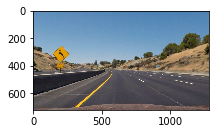

In [89]:
# image_path = 'test_images/straight_lines2.jpg'
image_path = 'test_images/test2.jpg'
undistorted_original = undistort_image(image_path, mtx, dist)
plt.subplot(211)
plt.imshow(undistorted_original)

## Apply Color and Gradient Threshold

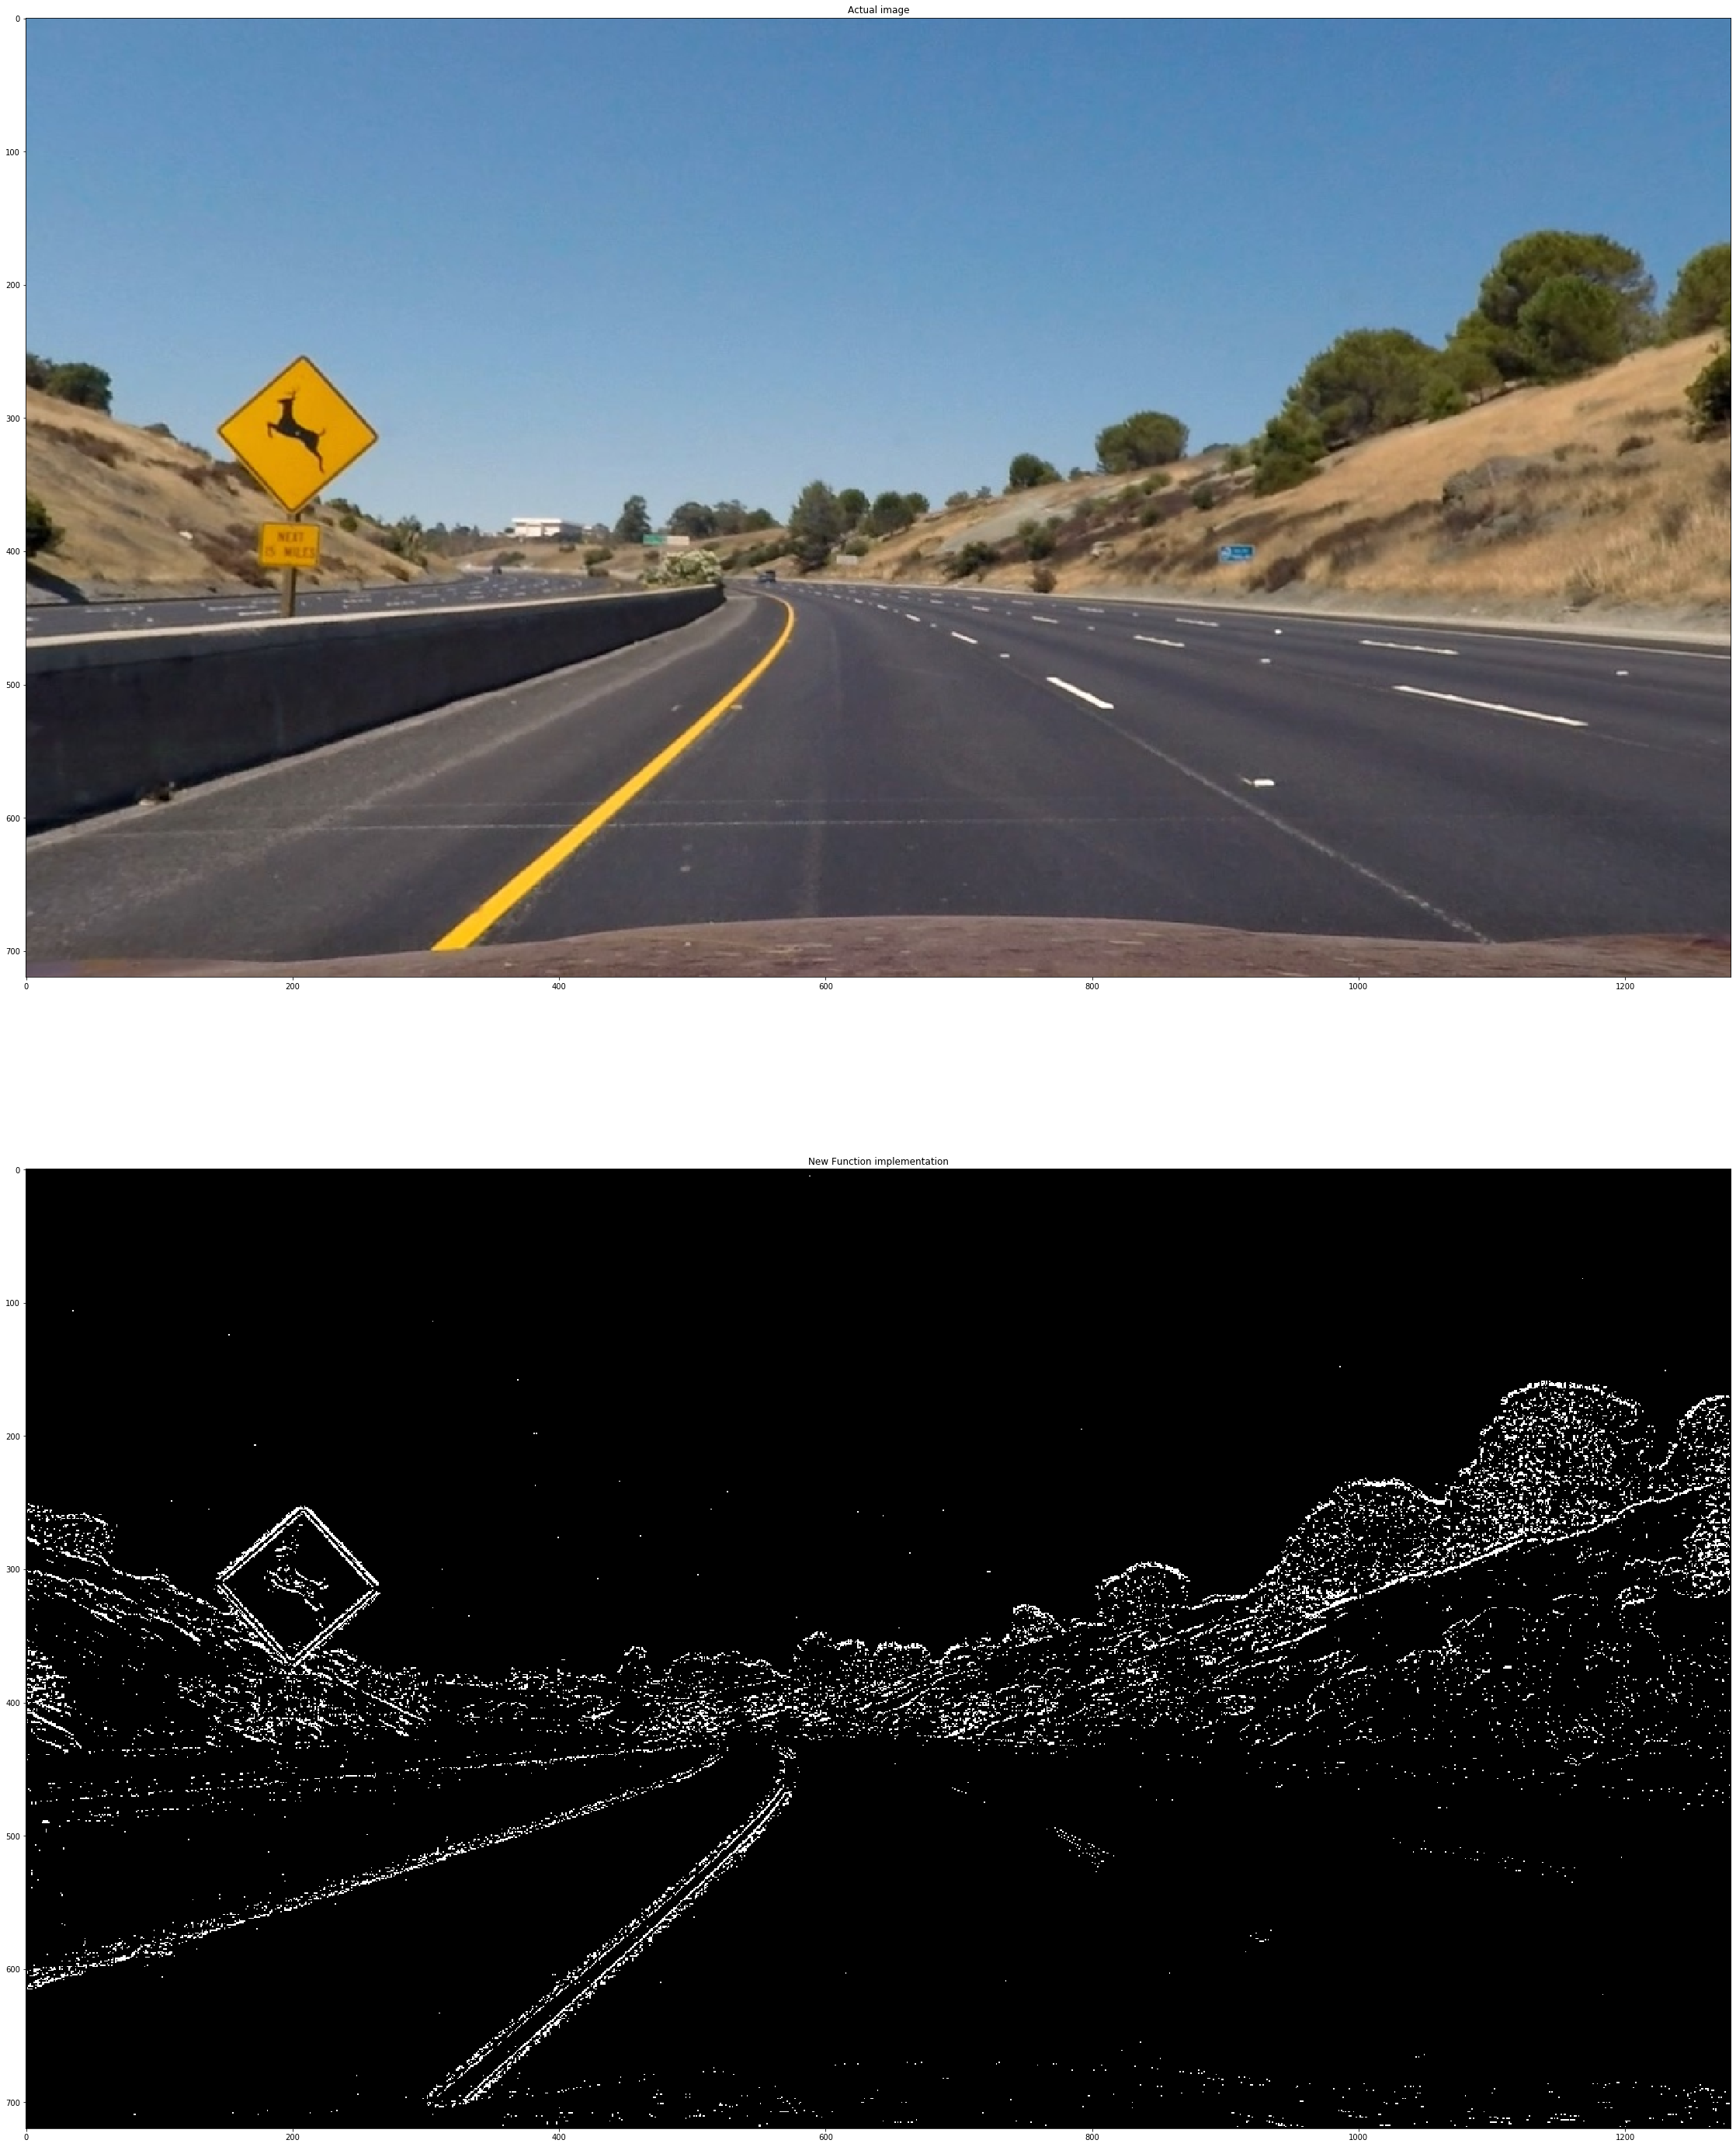

In [90]:
plt.figure(figsize=(40,50))

plt.subplot(211)
plt.title("Actual image")
plt.imshow(undistorted_original)

def apply_adaptive_thresholding(undistorted_color_image, channel_index_in_hls=2, kernel_size=5, correction=3):
    hls = cv2.cvtColor(undistorted_color_image, cv2.COLOR_RGB2HLS)
    return cv2.adaptiveThreshold(hls[:,:,channel_index_in_hls], 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY_INV, kernel_size, correction)


def get_sobel_xy(gray, x=0, y=0, kernel_size=5):
    assert x == 1 or y == 1, "Please select to apply sobel in either x direction or y direction"
    return cv2.Sobel(gray, cv2.CV_64F, x,y, kernel_size)


def apply_magnitude_thresholding(gray_img, sobel_x, sobel_y, threshold=(5,125)):
    #Get Absolute threshold
    absolute_sobel = np.sqrt(np.square(sobel_x) + np.square(sobel_y))
    #scaled thresholding
    scaled_sobel = np.uint8(255 * absolute_sobel/ np.max(absolute_sobel))
    binary_scaled = np.zeros_like(scaled_sobel)
    # Apply the thresholds
    binary_scaled[(scaled_sobel >= threshold[0]) & (scaled_sobel <= threshold[1])] = 1
    return binary_scaled


def apply_orientation_thresholding(sobel_x, sobel_y, threshold=(0.5,1.45)):
    #Direction threholding
    orientation = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    binary_orient = np.zeros_like(orientation)
    # Apply the thresholds
    binary_orient[(orientation >= threshold[0]) & (orientation <= threshold[1])] = 1
    return binary_orient


def get_magnitude_orientation_threshold(mag_binary_img, orient_binary_img):
    combined = np.zeros_like(orient_binary_img)
    combined[(orient_binary_img == 1) & (mag_binary_img == 1)] =1
    return combined


def combine_threshold_img(color_threshold, mag_orient_threshold_img):
    gradient = np.zeros_like(mag_orient_threshold_img)
    gradient[(color_threshold == 1) & (mag_orient_threshold_img ==1)] =1
    return gradient


color_threshold_img = apply_adaptive_thresholding(undistorted_original)
gray_img = cv2.cvtColor(undistorted_original, cv2.COLOR_RGB2GRAY)
sobel_x = get_sobel_xy(gray_img, 1,0)
sobel_y = get_sobel_xy(gray_img, 0,1)
magnitude_threshold_img = apply_magnitude_thresholding(gray_img, sobel_x, sobel_y)
orientation_threshold_img = apply_orientation_thresholding(sobel_x, sobel_y)
binary_image_threshold = get_magnitude_orientation_threshold(magnitude_threshold_img, orientation_threshold_img)
threshold_img = combine_threshold_img(color_threshold_img, binary_image_threshold)

plt.subplot(212)
plt.title("New Function implementation")
plt.imshow(threshold_img, cmap='gray')

## Performing Perspective Transformation of the image

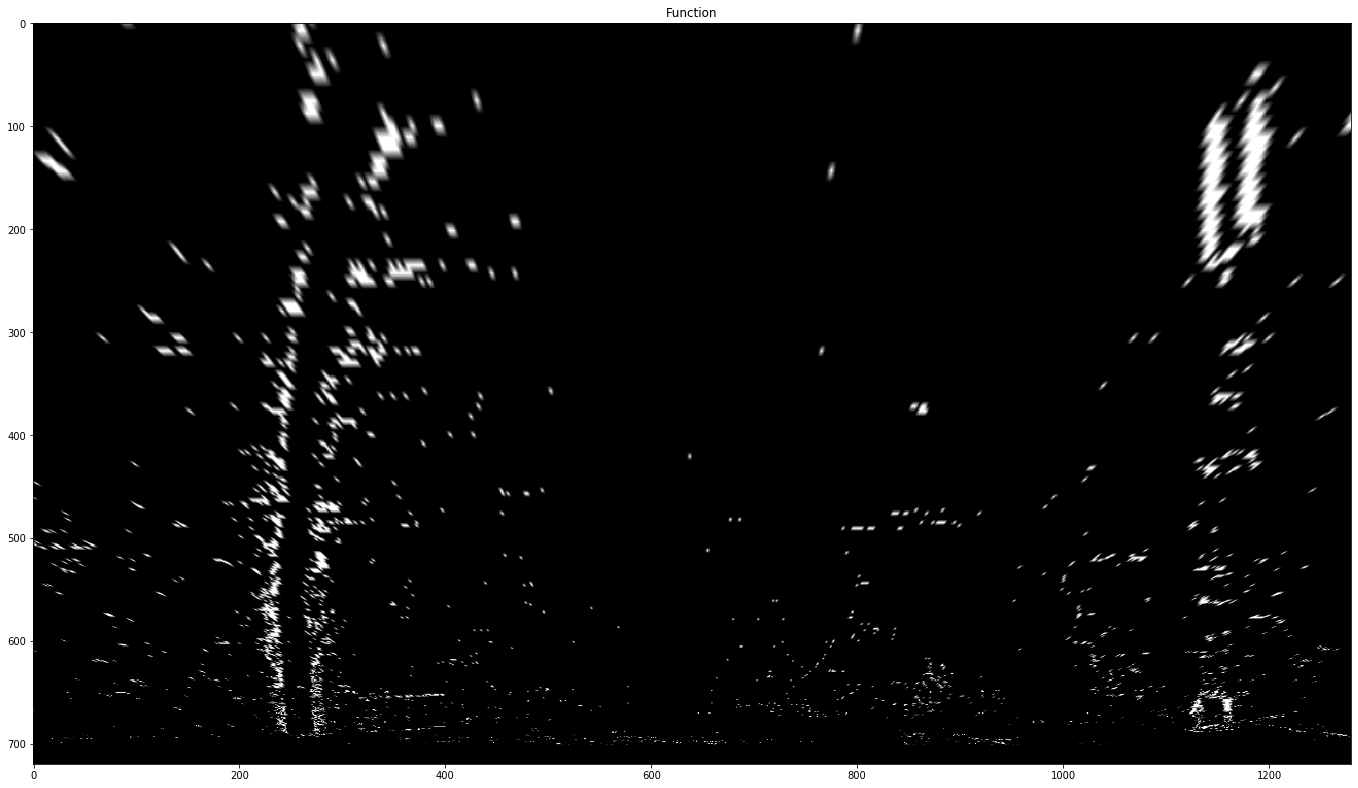

In [82]:
plt.figure(figsize=(30,30))
def get_src_dst_for_warp(undistorted_bin_img):
    h,w = undistorted_bin_img.shape
    # Constants defined to make the transformation independentent of image size
    midpoint = w // 2
    offset_midpoint = 120
    height_low = h //2 + 115
    height_hight = h - 50
    offset = 50
    
    src = np.array([[midpoint-offset_midpoint, height_low],[midpoint+offset_midpoint, height_low],
                [midpoint+4.2*offset_midpoint, height_hight],[midpoint-4.2*offset_midpoint, height_hight]], np.float32)

    
    dst = np.array([[offset, offset],[w - offset, offset],
                    [w - offset, height_hight],[offset, height_hight]], np.float32)
    
#     plt.subplot(211)
#     plt.scatter(midpoint-offset_midpoint, height_low, color='red')
#     plt.scatter(midpoint+offset_midpoint, height_low, color='green')
#     plt.scatter(midpoint+4.2*offset_midpoint, height_hight, color='white')
#     plt.scatter(midpoint-4.2*offset_midpoint, height_hight, color='blue')

#     plt.scatter(20, offset, color='red')
#     plt.scatter(w-20, offset, color='green')
#     plt.scatter(w-20, height_hight, color='white')
#     plt.scatter(20, height_hight, color='blue')
#     plt.imshow(undistorted_bin_img, cmap='gray')
    return src,dst
    
def apply_perspective_transform(undistorted_bin_img, src, dst):
    h,w = undistorted_bin_img.shape[0], undistorted_bin_img.shape[1]
    M = cv2.getPerspectiveTransform(src,dst)
    return cv2.warpPerspective(undistorted_bin_img, M, (w,h), cv2.INTER_LINEAR)

src, dst = get_src_dst_for_warp(threshold_img)
warp_img = apply_perspective_transform(threshold_img, src, dst)


plt.subplot(212)
plt.title("Function")
plt.imshow(warp_img, cmap='gray')

## Finding Lane Lines

### 1. Finding Lane Lines for the First Frame

In [83]:
def get_initial_pixel_values(warp_img):
    #Get the histogram for just the bottom part of the image
    hist = np.sum(warp_img[warp_img.shape[0]//2:, :], axis=0)
    midpoint = len(hist) // 2
    left = np.argmax(hist[: midpoint])
    right = np.argmax(hist[midpoint :]) + midpoint
    return left, right

#### It was found that the difference between the lane lines in Warped Image for the Current transfom is 600pixels

### 2. Try to find the PolyNomial

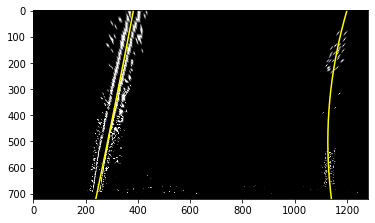

In [97]:
def search_lane_lines(warp_img, nwindows=20, minpixels=70, margin=100):
    
    left_current, right_current = get_initial_pixel_values(warp_img)
#     print("Initial left and right pixel indices: {}".format(get_initial_pixel_values(warp_img)))
    height, width = warp_img.shape
    nonzero = np.nonzero(warp_img)
    nonzerox = nonzero[1]
    nonzeroy = nonzero[0]
    window_height = height // nwindows
    left_inds = []
    right_inds = []
    
    for i in range(nwindows):
        win_height_high = height - i*window_height
        win_height_low = height - (i+1)*window_height

        win_left_min = left_current - margin
        win_left_max = left_current + margin
        win_right_min = right_current - margin
        win_right_max = right_current + margin

#         print("Win Height[{}, {}], left Wind[{},{}], Right Wind[{},{}]"
#           .format(win_height_low, win_height_high, win_left_min, win_left_max,
#                  win_right_min, win_right_max))

        left_current_inds = ((nonzeroy >= win_height_low)&(nonzeroy <= win_height_high)&
                             (nonzerox >= win_left_min)&(nonzerox <= win_left_max)).nonzero()[0]
        right_current_inds = ((nonzeroy >= win_height_low)&(nonzeroy <= win_height_high)&
                             (nonzerox >= win_right_min)&(nonzerox <= win_right_max)).nonzero()[0]

        left_inds.append(left_current_inds)
        right_inds.append(right_current_inds)

        if len(left_current_inds) > minpixels:
            left_current =  int(np.mean(nonzerox[left_current_inds]))
        if len(right_current_inds) > minpixels:
            right_current =  int(np.mean(nonzerox[right_current_inds]))
    
    left_inds = np.concatenate(left_inds)
    right_inds = np.concatenate(right_inds) 
    
    left_x = nonzerox[left_inds]
    left_y = nonzeroy[left_inds]
    right_x = nonzerox[right_inds]
    right_y = nonzeroy[right_inds]
    
    return left_x, left_y, right_x, right_y

def poly_fit(warp_img, left_x, left_y, right_x, right_y):
    left_fit = np.polyfit(left_y, left_x, 2)
    right_fit = np.polyfit(right_y, right_x, 2)
    
    ploty = np.linspace(0, warp_img.shape[0]-1, warp_img.shape[0])
    left_fitx = left_fit[0]*(ploty**2) + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*(ploty**2) + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty


left_x, left_y, right_x, right_y = search_lane_lines(warp_img)
left_fitx, right_fitx, ploty = poly_fit(warp_img, left_x, left_y, right_x, right_y)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

plt.imshow(warp_img, cmap='gray')

In [85]:
def draw_polygon(img, left_fitx, right_fitx, ploty):
    #Scaling the model
    out_img = np.dstack((img, img, img)) *255
    window_img = np.zeros_like(out_img)
    #Arranging the x,y points in a order to fit the polygon
    left_line_points = np.array([np.vstack((left_fitx, ploty)).T])
    right_line_points = np.array([np.flipud(np.vstack((right_fitx, ploty)).T)])
    lane_pts = np.hstack((left_line_points, right_line_points))
    # Fitting the Polygon
    cv2.fillPoly(window_img, np.int_([lane_pts]), (0,255,0))
    return cv2.addWeighted(out_img, 0.0, window_img, 0.99, 0)

In [86]:
ym_per_pix = 30/720 
xm_per_pix = 3.7/700

def find_radius_of_curvature(left_fitx, right_fitx, ploty):
    left_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    y_eval = np.max(ploty)
    left_curverad = (1 + (2*left_cr[0]*y_eval*ym_per_pix + left_cr[1])**2)**1.5 / np.absolute(2*left_cr[0]) ## Implement the calculation of the left line here
    right_curverad = (1 + (2*right_cr[0]*y_eval*ym_per_pix + right_cr[1])**2)**1.5 / np.absolute(2*right_cr[0])  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad  

In [87]:
ret, mtx, dist, rvec, tvec = camera_calibration("camera_cal/")

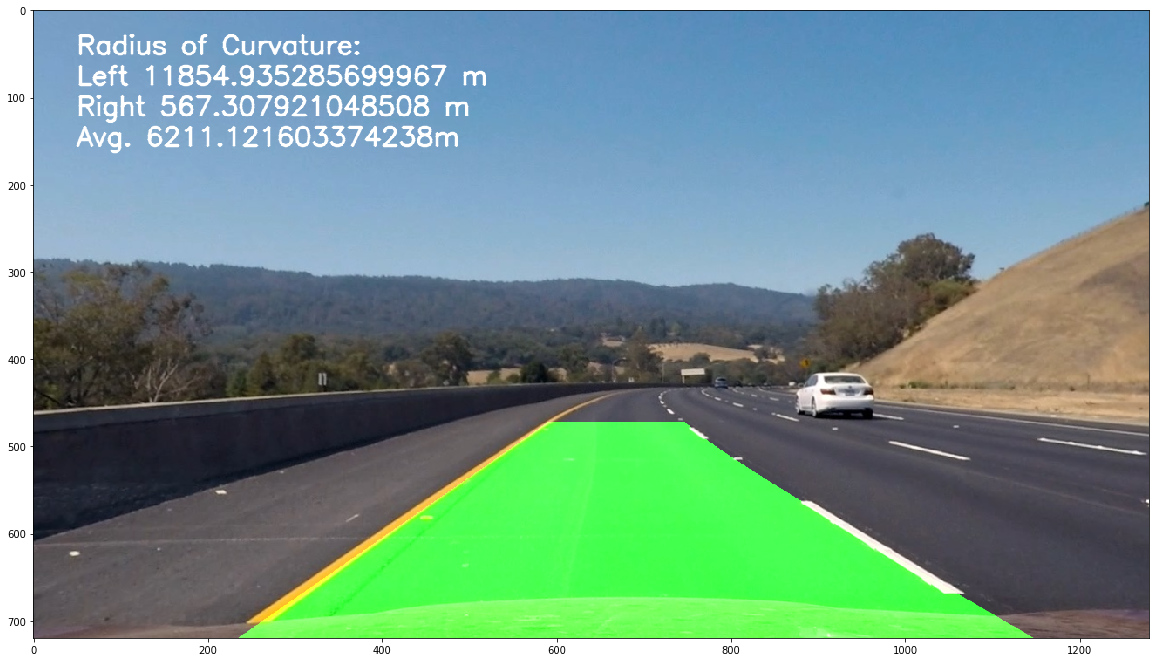

In [98]:
image_path = 'test_images/test3.jpg'

#Undistorting image
undistorted_original = undistort_image(image_path, mtx, dist)

#Thresholding
color_threshold_img = apply_adaptive_thresholding(undistorted_original)
gray_img = cv2.cvtColor(undistorted_original, cv2.COLOR_RGB2GRAY)
sobel_x = get_sobel_xy(gray_img, 1,0)
sobel_y = get_sobel_xy(gray_img, 0,1)
magnitude_threshold_img = apply_magnitude_thresholding(gray_img, sobel_x, sobel_y)
orientation_threshold_img = apply_orientation_thresholding(sobel_x, sobel_y)
binary_image_threshold = get_magnitude_orientation_threshold(magnitude_threshold_img, orientation_threshold_img)
threshold_img = combine_threshold_img(color_threshold_img, binary_image_threshold)

#Apply perspective transform
src, dst = get_src_dst_for_warp(threshold_img)
warp_img = apply_perspective_transform(threshold_img, src, dst)

#Search for Lane Lines
left_x, left_y, right_x, right_y = search_lane_lines(warp_img)
left_fitx, right_fitx, ploty = poly_fit(warp_img, left_x, left_y, right_x, right_y)

#Applying the Polygon
result = draw_polygon(warp_img, left_fitx, right_fitx, ploty)

# Calculate Radius of Curvature
left_curverad, right_curverad = find_radius_of_curvature(left_fitx, right_fitx, ploty)

#Getting inverse transforms to put the polygon on main image
un_warp_img = apply_perspective_transform(result, dst, src)
img_n = cv2.normalize(src=un_warp_img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

actual_image_region = cv2.addWeighted(undistorted_original, 1, img_n , 0.8,0)
text = "Radius of Curvature:\nLeft {} m\nRight {} m\nAvg. {}m".format(left_curverad, right_curverad,
                                                        (left_curverad + right_curverad) / 2)
font = cv2.FONT_HERSHEY_SIMPLEX
y0, dy = 50, 35
for i,line in enumerate(text.split("\n")):
    y = y0 + i*dy
    cv2.putText(actual_image_region, line, (y0 ,y), font, 1, (255, 255, 255), 2, cv2.LINE_AA)

plt.figure(figsize=(20,20))
plt.imshow(actual_image_region)